# Setting

In [2]:
from __future__ import print_function
import os, sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from annoy import AnnoyIndex
import pandas as pd
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)
from embedding_wrapper import Embedding
from pose_wrapper import Headpose
from config import Config

def human_sort(s):
    import re
    pattern = r"([0-9]+)"
    return [int(c) if c.isdigit() else c.lower()
            for c in re.split(pattern, s)]

config = Config()
u = AnnoyIndex(512, metric="euclidean")
u.load(config.FACE_FEATURES)
face_list = [x[:-4] for x in pd.read_csv(config.FACE_NAMES, names=["object_name"]).object_name]
embedding = Embedding()
headpose = Headpose()

/home/buggy/.pyenv/versions/2.7.15/lib/python2.7/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


# 参照画像

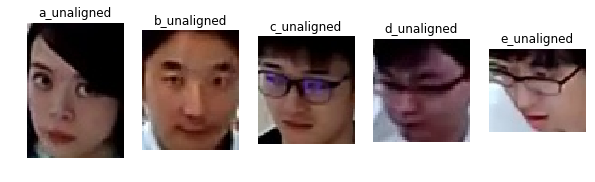

<Figure size 720x720 with 0 Axes>

In [4]:
FACE_DB_PATH = os.path.join(config.IMAGE_PATH,"face_db")
UNALIGNED_FACE_DB_PATH = os.path.join(FACE_DB_PATH, "backup")

face_db_image_names = [image for image in os.listdir(FACE_DB_PATH) if image.endswith(".jpg")]
face_db_image_names.sort(key=human_sort)
face_db_images = [cv2.imread(os.path.join(FACE_DB_PATH, face_db_image_name)) for face_db_image_name in face_db_image_names]
face_db_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in face_db_images]
poses = [headpose.get_pose(img) for img in face_db_images]
[headpose.draw_axis(img, pose[0], pose[1], pose[2], img.shape[0], img.shape[1]) for img, pose in zip(face_db_images, poses)]


unaligned_face_db_images = [cv2.imread(os.path.join(UNALIGNED_FACE_DB_PATH, obj_name + ".jpg")) for obj_name in face_list]
unaligned_face_db_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in unaligned_face_db_images]

%matplotlib inline
ROWS = 2
DEFAULT_SIZE = 10
FIGSIZE = (DEFAULT_SIZE, DEFAULT_SIZE)
plt.figure(figsize=FIGSIZE)

for i, (face_indx, img) in enumerate(zip(face_list, unaligned_face_db_images)):
    plt.subplot(ROWS,len(face_list),i+1)
    plt.title(face_indx + "_unaligned")
    plt.axis('off')
    plt.imshow(img)
plt.show()
plt.close()

plt.figure(figsize=FIGSIZE)
for i, (face_indx, img) in enumerate(zip(face_list, face_db_images)):
    plt.subplot(ROWS,len(face_list),len(face_list)+i+1)
    plt.title(face_indx)
    plt.axis('off')
    plt.imshow(img)

for face, pose in zip(face_list, poses):
    print("対象 {} のテスト画像".format(face))
    print("Yaw:{}, Pitch:{}, Roll:{}".format(pose[0], pose[1], pose[2]))

# テスト画像

----------------------------------------------------------------------------------------------------
対象 a のテスト画像


<Figure size 720x720 with 0 Axes>

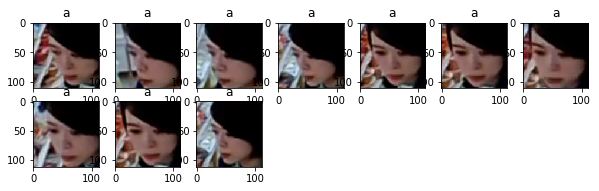

----------------------------------------------------------------------------------------------------
対象 b のテスト画像


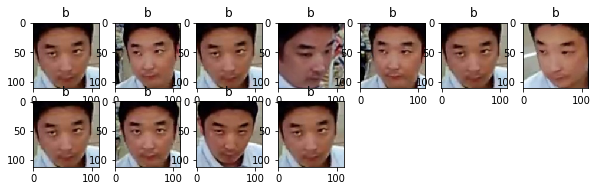

----------------------------------------------------------------------------------------------------
対象 c のテスト画像


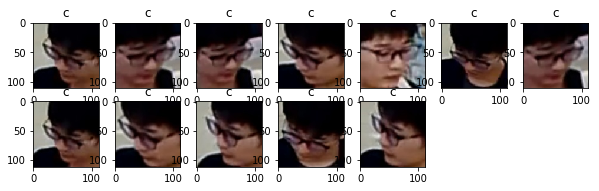

----------------------------------------------------------------------------------------------------
対象 d のテスト画像


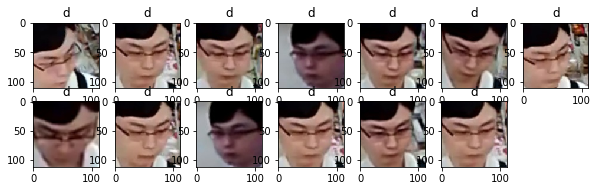

----------------------------------------------------------------------------------------------------
対象 e のテスト画像


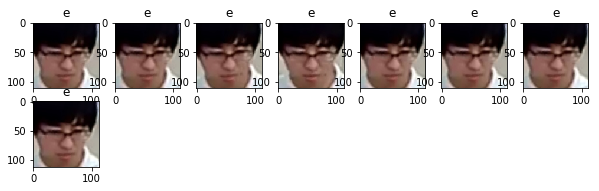

In [5]:
from math import ceil

IMAGES_PER_ROW = 7

DEFAULT_SIZE = 10
FIGSIZE = (DEFAULT_SIZE, DEFAULT_SIZE)
plt.figure(figsize=FIGSIZE)

for j, face in enumerate(face_list):
    print("----------------------------------------------------------------------------------------------------")
    print("対象 {} のテスト画像".format(face))
    current_test_path = os.path.join(config.TEST_PATH, face)
    images = [image for image in os.listdir(current_test_path) if image.endswith(".jpg")]
    imgs = [cv2.imread(os.path.join(current_test_path, image)) for image in images]
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

    num_images = len(imgs)
    rows = 2
    plt.figure(figsize=FIGSIZE)
    plt.subplots_adjust(bottom=.1, top=.3)
    for i, img in enumerate(imgs):
        plt.subplot(rows,IMAGES_PER_ROW,i+1)
        plt.title(face)
        plt.imshow(img)
    plt.show()
    plt.close()    

# 全体精度

In [7]:
total = 0
correct = 0
for face in face_list:    
    current_test_path = os.path.join(config.TEST_PATH, face)
    images = [image for image in os.listdir(current_test_path) if image.endswith(".jpg")]
    imgs = [cv2.imread(os.path.join(current_test_path, image)) for image in images]

    total += len(imgs)
    for img in imgs:
        e = embedding.get_feature(img)
        match = u.get_nns_by_vector(e, 1, search_k=1000, include_distances=True)
        identified_face = face_list[(match[0][0])]
        if (identified_face == face):
            correct += 1

print("全体の画像数: {}".format(total))
print("認証が正しい画像数: {}".format(correct))
print("全体精度: {}".format(float(correct)/total))

全体の画像数: 54
認証が正しい画像数: 47
全体精度: 0.87037037037


----------------------------------------------------------------------------------------------------
対象 a のテスト画像
Yaw:38.7721405029, Pitch:-46.1004867554, Roll:-11.9370422363
Yaw:43.7243041992, Pitch:-40.4981842041, Roll:-16.9737854004
Yaw:49.2228088379, Pitch:-42.0013656616, Roll:-16.3115234375
Yaw:45.952545166, Pitch:-43.4638252258, Roll:-7.0075302124
Yaw:18.3998718262, Pitch:-36.9605484009, Roll:-10.1622009277
Yaw:17.4881591797, Pitch:-36.1871643066, Roll:-10.8958587646
Yaw:21.7301559448, Pitch:-37.2807884216, Roll:-6.74906921387
Yaw:27.2496948242, Pitch:-37.0358200073, Roll:-10.6450042725
Yaw:16.4697418213, Pitch:-35.5977249146, Roll:-11.1886444092
Yaw:50.0721893311, Pitch:-37.8296508789, Roll:-9.07879638672


/home/buggy/publicWorkspace/dev/face_recognition_survey/thirdparty/pose/deep_head_pose/hopenet_pose.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yaw_predicted = F.softmax(yaw)
/home/buggy/publicWorkspace/dev/face_recognition_survey/thirdparty/pose/deep_head_pose/hopenet_pose.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pitch_predicted = F.softmax(pitch)
/home/buggy/publicWorkspace/dev/face_recognition_survey/thirdparty/pose/deep_head_pose/hopenet_pose.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  roll_predicted = F.softmax(roll)


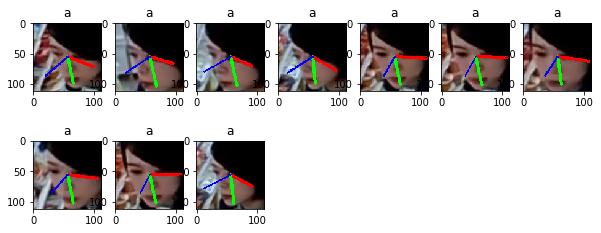

対象画像数: 10
認証が正しい画像数: 10
全体精度: 1.0
----------------------------------------------------------------------------------------------------
対象 b のテスト画像
Yaw:-4.53527069092, Pitch:-22.755645752, Roll:-3.22860717773
Yaw:11.6461791992, Pitch:-17.8001480103, Roll:-4.92756652832
Yaw:-4.36912536621, Pitch:-22.3448791504, Roll:-3.07852172852
Yaw:-30.6598815918, Pitch:-29.4631652832, Roll:8.16361999512
Yaw:10.1292877197, Pitch:-12.9508666992, Roll:-0.883193969727
Yaw:-4.55477905273, Pitch:-22.747467041, Roll:-3.23036193848
Yaw:18.9741897583, Pitch:-27.9814147949, Roll:-8.22081756592
Yaw:-4.53527069092, Pitch:-22.755645752, Roll:-3.22860717773
Yaw:3.50132751465, Pitch:-18.4381408691, Roll:-1.88516235352
Yaw:-7.31494903564, Pitch:-27.9262237549, Roll:2.89659118652
Yaw:-4.53527069092, Pitch:-22.755645752, Roll:-3.22860717773


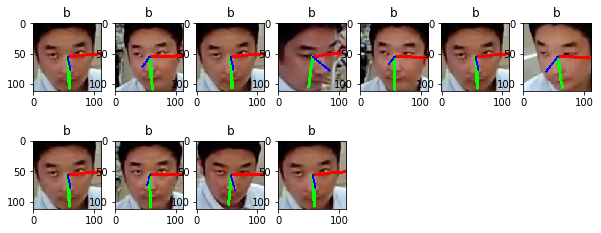

対象画像数: 11
認証が正しい画像数: 11
全体精度: 1.0
----------------------------------------------------------------------------------------------------
対象 c のテスト画像
Yaw:64.1491394043, Pitch:-40.8565216064, Roll:7.46248626709
Yaw:-14.0138549805, Pitch:-46.6692581177, Roll:-1.52381896973
Yaw:-24.2696838379, Pitch:-41.6740722656, Roll:5.43901062012
Yaw:42.148727417, Pitch:-44.370059967, Roll:-14.2292633057
Yaw:-18.5588302612, Pitch:-30.4172286987, Roll:3.11514282227
Yaw:40.5479125977, Pitch:-49.3844261169, Roll:-4.19577789307
Yaw:-13.2682037354, Pitch:-47.284324646, Roll:-2.76110839844
Yaw:66.7496643066, Pitch:-41.5088653564, Roll:6.87160491943
Yaw:42.673248291, Pitch:-42.9509963989, Roll:-16.7265548706
Yaw:49.0488891602, Pitch:-34.6880722046, Roll:-4.1904296875
Yaw:42.3975067139, Pitch:-48.7138710022, Roll:-3.89022827148
Yaw:51.0835876465, Pitch:-24.3786239624, Roll:0.18896484375


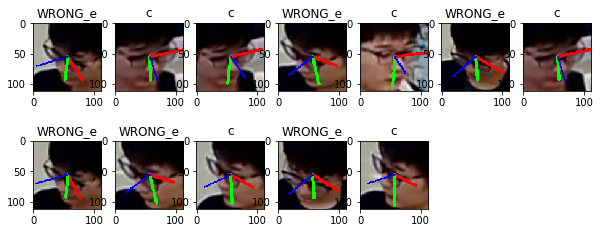

対象画像数: 12
認証が正しい画像数: 6
全体精度: 0.5
----------------------------------------------------------------------------------------------------
対象 d のテスト画像
Yaw:-37.2223320007, Pitch:-42.7206726074, Roll:-2.18760681152
Yaw:-12.6238250732, Pitch:-32.661819458, Roll:0.633117675781
Yaw:-8.23593902588, Pitch:-28.3663635254, Roll:1.02395629883
Yaw:16.6872406006, Pitch:-16.1820297241, Roll:-8.25923919678
Yaw:-10.1383666992, Pitch:-28.4912414551, Roll:2.16638183594
Yaw:-5.89447784424, Pitch:-40.2934646606, Roll:8.854637146
Yaw:-25.8120193481, Pitch:-43.7378616333, Roll:-3.07559967041
Yaw:-4.60008239746, Pitch:-51.7546386719, Roll:3.71989440918
Yaw:-14.3238220215, Pitch:-37.3590660095, Roll:3.83770751953
Yaw:18.0622787476, Pitch:-15.8002166748, Roll:-11.6192398071
Yaw:-11.4652862549, Pitch:-32.4247970581, Roll:-0.701751708984
Yaw:-12.4303359985, Pitch:-28.2822570801, Roll:-2.68812561035
Yaw:-11.4628448486, Pitch:-32.4128875732, Roll:-0.694747924805


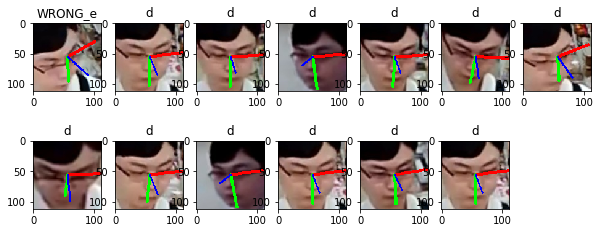

対象画像数: 13
認証が正しい画像数: 12
全体精度: 0.923076923077
----------------------------------------------------------------------------------------------------
対象 e のテスト画像
Yaw:-9.20050811768, Pitch:-13.3556442261, Roll:2.40435791016
Yaw:-8.96203613281, Pitch:-14.6579666138, Roll:1.57530212402
Yaw:-5.63391876221, Pitch:-13.0283050537, Roll:-1.86261749268
Yaw:-0.769897460938, Pitch:-10.546875, Roll:-1.64671325684
Yaw:-8.96203613281, Pitch:-14.6579666138, Roll:1.57530212402
Yaw:-8.91882324219, Pitch:-14.6538925171, Roll:1.65510559082
Yaw:-8.96907806396, Pitch:-14.6266784668, Roll:1.56674194336
Yaw:-8.96203613281, Pitch:-14.6579666138, Roll:1.57530212402


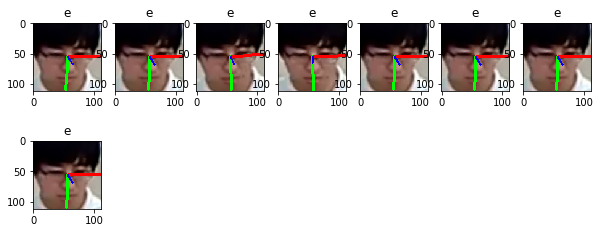

対象画像数: 8
認証が正しい画像数: 8
全体精度: 1.0


In [8]:
import copy

temp = None
for face in face_list:
    print("----------------------------------------------------------------------------------------------------")
    print("対象 {} のテスト画像".format(face))
    current_test_path = os.path.join(config.TEST_PATH, face)
    images = [image for image in os.listdir(current_test_path) if image.endswith(".jpg")]
    imgs = [cv2.imread(os.path.join(current_test_path, image)) for image in images]
    imgs_for_poses = copy.deepcopy(imgs)
    poses = [headpose.get_pose(img) for img in imgs_for_poses]
    [headpose.draw_axis(img, pose[0], pose[1], pose[2], img.shape[0], img.shape[1]) for img, pose in zip(imgs_for_poses, poses)]

    for pose in poses:
        print("Yaw:{}, Pitch:{}, Roll:{}".format(pose[0], pose[1], pose[2]))

    sub_total = len(imgs)
    sub_correct = 0
    rows = 2
    plt.figure(figsize=FIGSIZE)
    plt.subplots_adjust(bottom=.5, top=.8)

    for i, img in enumerate(imgs):
        e = embedding.get_feature(img)
        temp = e
        match = u.get_nns_by_vector(e, 1, search_k=1000, include_distances=True)
        identified_face = face_list[(match[0][0])]
        plt.subplot(rows,IMAGES_PER_ROW,i+1)
        if (identified_face == face):
            sub_correct += 1
            plt.title(face)
        else:
            plt.title("WRONG_{}".format(identified_face))
            
        plt.imshow(cv2.cvtColor(imgs_for_poses[i], cv2.COLOR_BGR2RGB))
    plt.show()
    plt.close()
        
    print("対象画像数: {}".format(sub_total))
    print("認証が正しい画像数: {}".format(sub_correct))
    print("全体精度: {}".format(float(sub_correct)/sub_total))